# 単純支持の片持ち梁での検討

GetFEM++を使用して単純支持の片持ち梁に荷重を与え、理論解との比較をします。

In [1]:
import os
import sys
sys.path.append('../getfem/interface/src/python/')
import getfem as gf
import numpy as np

検討するケースは次の通りです。GetFEM++において下に示す有限要素法と積分をそれぞれFEM_PRODUCTとIM_PRDOCTを使用して2次元化して使用します。2次要素についてはガウスの積分点が3として解析を行います。IM_GAUSS1D(K)はK/2+1点のガウス積分を表します。

| ケース名 | 要素定式化       | 分割    | 有限要素法                     | 積分            |
| -------- | ---------------- | ------- | ------------------------------ | --------------- |
| case11   | 2次要素          | 1×4    | FEM_PK(1, 2)                   | IM_GAUSS1D(4)   |
| case12   | 2次要素          | 2×4    | FEM_PK(1, 2)                   | IM_GAUSS1D(4)   |
| case13   | 2次要素          | 4×4    | FEM_PK(1, 2)                   | IM_GAUSS1D(4)   |
| case14   | 2次要素          | 8×16   | FEM_PK(1, 2)                   | IM_GAUSS1D(4)   |
| case21   | 1次完全積分要素  | 1×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(2)   |
| case22   | 1次完全積分要素  | 2×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(2)   |
| case23   | 1次完全積分要素  | 4×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(2)   |
| case24   | 1次完全積分要素  | 8×16   | FEM_PK(1, 1)                   | IM_GAUSS1D(2)   |
| case31   | 1次低減積分要素  | 1×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(0)   |
| case32   | 1次低減積分要素  | 2×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(0)   |
| case33   | 1次低減積分要素  | 4×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(0)   |
| case34   | 1次低減積分要素  | 8×16   | FEM_PK(1, 1)                   | IM_GAUSS1D(0)   |
| case41   | 1次非適合要素    | 1×4    | FEM_PK_WITH_CUBIC_BUBBLE(1, 1) | IM_GAUSS1D(4)   |
| case42   | 1次非適合要素    | 2×4    | FEM_PK_WITH_CUBIC_BUBBLE(1, 1) | IM_GAUSS1D(4)   |
| case43   | 1次非適合要素    | 4×4    | FEM_PK_WITH_CUBIC_BUBBLE(1, 1) | IM_GAUSS1D(4)   |
| case44   | 1次非適合要素    | 8×16   | FEM_PK_WITH_CUBIC_BUBBLE(1, 1) | IM_GAUSS1D(4)   |

それでは、これらの有限要素法と積分法をそれぞれ設定します。メッシュを最初に設定します。モデル全体のサイズはX方向に10、Y方向に1とします。一般的に細長比（スレンダー比）が1:10であれば梁とみなせると言われています。(http://femingway.com/?p=1310)

In [2]:
x = 10.0
y = 1.0

x01 = np.arange(1+1)*1/1
x04 = np.arange(4+1)*x/4
x16 = np.arange(16+1)*x/16

y01 = np.arange(1+1)*y/1
y02 = np.arange(2+1)*y/2
y04 = np.arange(4+1)*y/4
y08 = np.arange(8+1)*y/8

m0101 = gf.Mesh('cartesian', x01, y01)
m0104 = gf.Mesh('cartesian', x04, y01)
m0204 = gf.Mesh('cartesian', x04, y02)
m0404 = gf.Mesh('cartesian', x04, y04)
m0816 = gf.Mesh('cartesian', x16, y08)

m0101.export_to_vtk('m0101.vtk')
m0104.export_to_vtk('m0104.vtk')
m0204.export_to_vtk('m0204.vtk')
m0404.export_to_vtk('m0404.vtk')
m0816.export_to_vtk('m0816.vtk')

In [3]:
def plot_vtk(filename, picturename):
    from mayavi import mlab
    mlab.init_notebook()
    vtk_file_reader = mlab.pipeline.open(filename)
    extract_edges = mlab.pipeline.extract_edges(vtk_file_reader)
    surface = mlab.pipeline.surface(extract_edges)
    axes = mlab.axes(surface)
    
    mlab.show()
    mlab.savefig(picturename)
    mlab.clf()
    from IPython.display import Image, display_png
    display_png(Image(picturename))

Notebook initialized with ipy backend.


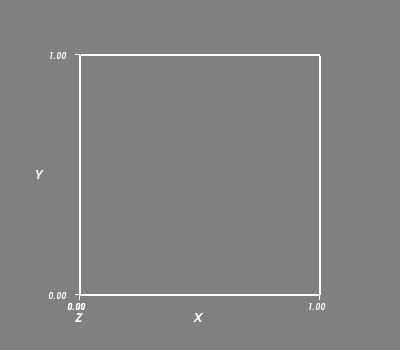

In [4]:
plot_vtk(filename = 'm0101.vtk', picturename = 'm0101.png')

1×4のメッシュを表示します。

Notebook initialized with ipy backend.


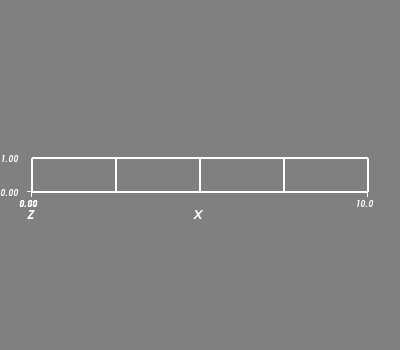

In [5]:
plot_vtk(filename = 'm0104.vtk', picturename = 'm0104.png')

2×4のメッシュを表示します。

Notebook initialized with ipy backend.


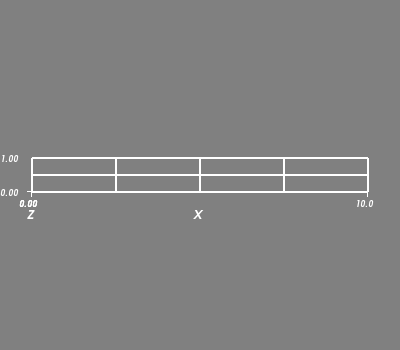

In [6]:
plot_vtk(filename = 'm0204.vtk', picturename = 'm0204.png')

4×4のメッシュを表示します。

Notebook initialized with ipy backend.


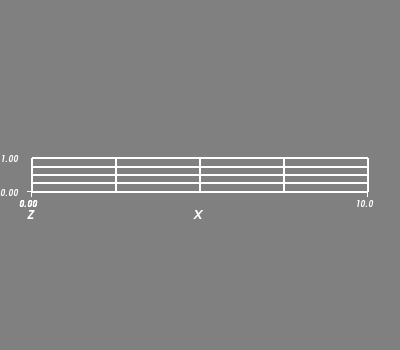

In [7]:
plot_vtk(filename = 'm0404.vtk', picturename = 'm0404.png')

8×16のメッシュを表示します。

Notebook initialized with ipy backend.


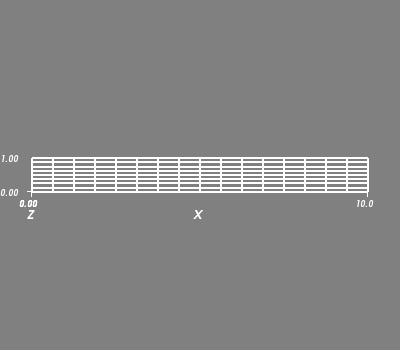

In [8]:
plot_vtk(filename = 'm0816.vtk', picturename = 'm0816.png')

各メッシュの左側面にDirichlet条件を設定するための境界領域を設定します。各メッシュの右側面にNeumann条件を設定するための境界領域を設定します。

In [9]:
flst0104 = m0104.outer_faces()
flst0204 = m0204.outer_faces()
flst0404 = m0404.outer_faces()
flst0816 = m0816.outer_faces()

fnor0104 = m0104.normal_of_faces(flst0104)
fnor0204 = m0204.normal_of_faces(flst0204)
fnor0404 = m0404.normal_of_faces(flst0404)
fnor0816 = m0816.normal_of_faces(flst0816)

tright0104 = abs(fnor0104[0, :] - 1) < 1e-14
tright0204 = abs(fnor0204[0, :] - 1) < 1e-14
tright0404 = abs(fnor0404[0, :] - 1) < 1e-14
tright0816 = abs(fnor0816[0, :] - 1) < 1e-14

tleft0104 = abs(fnor0104[0, :] + 1) < 1e-14
tleft0204 = abs(fnor0204[0, :] + 1) < 1e-14
tleft0404 = abs(fnor0404[0, :] + 1) < 1e-14
tleft0816 = abs(fnor0816[0, :] + 1) < 1e-14

fright0104 = np.compress(tright0104, flst0104, axis=1)
fright0204 = np.compress(tright0204, flst0204, axis=1)
fright0404 = np.compress(tright0404, flst0404, axis=1)
fright0816 = np.compress(tright0816, flst0816, axis=1)

fleft0104 = np.compress(tleft0104, flst0104, axis=1)
fleft0204 = np.compress(tleft0204, flst0204, axis=1)
fleft0404 = np.compress(tleft0404, flst0404, axis=1)
fleft0816 = np.compress(tleft0816, flst0816, axis=1)

right = 1
left = 2

m0104.set_region(right, fright0104)
m0204.set_region(right, fright0204)
m0404.set_region(right, fright0404)
m0816.set_region(right, fright0816)

m0104.set_region(left, fleft0104)
m0204.set_region(left, fleft0204)
m0404.set_region(left, fleft0404)
m0816.set_region(left, fleft0816)

MeshFEMオブジェクトを作成し各メッシュと有限要素法を関連付けます。

In [10]:
mfu11 = gf.MeshFem(m0104, 2)
mfu12 = gf.MeshFem(m0204, 2)
mfu13 = gf.MeshFem(m0404, 2)
mfu14 = gf.MeshFem(m0816, 2)
mfu21 = gf.MeshFem(m0104, 2)
mfu22 = gf.MeshFem(m0204, 2)
mfu23 = gf.MeshFem(m0404, 2)
mfu24 = gf.MeshFem(m0816, 2)
mfu31 = gf.MeshFem(m0104, 2)
mfu32 = gf.MeshFem(m0204, 2)
mfu33 = gf.MeshFem(m0404, 2)
mfu34 = gf.MeshFem(m0816, 2)
mfu41 = gf.MeshFem(m0104, 2)
mfu42 = gf.MeshFem(m0204, 2)
mfu43 = gf.MeshFem(m0404, 2)
mfu44 = gf.MeshFem(m0816, 2)

fem1 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 2), FEM_PK(1, 2))') # 2次要素
fem2 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))') # 1次要素
fem3 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))') # 1次要素
fem4 = gf.Fem('FEM_PRODUCT(FEM_PK_WITH_CUBIC_BUBBLE(1, 1), FEM_PK_WITH_CUBIC_BUBBLE(1, 1))') # 非適合要素

mfu11.set_fem(fem1)
mfu12.set_fem(fem1)
mfu13.set_fem(fem1)
mfu14.set_fem(fem1)
mfu21.set_fem(fem2)
mfu22.set_fem(fem2)
mfu23.set_fem(fem2)
mfu24.set_fem(fem2)
mfu31.set_fem(fem3)
mfu32.set_fem(fem3)
mfu33.set_fem(fem3)
mfu34.set_fem(fem3)
mfu41.set_fem(fem4)
mfu42.set_fem(fem4)
mfu43.set_fem(fem4)
mfu44.set_fem(fem4)

積分法を定義します。

In [11]:
inm1 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))') # 2次完全積分
inm2 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(2), IM_GAUSS1D(2))') # 1次完全積分
inm3 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(0), IM_GAUSS1D(0))') # 1次低減積分
inm4 = gf.Integ('IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))') # 非適合要素完全積分

In [12]:
mim11 = gf.MeshIm(m0104, inm1)
mim12 = gf.MeshIm(m0204, inm1)
mim13 = gf.MeshIm(m0404, inm1)
mim14 = gf.MeshIm(m0816, inm1)
mim21 = gf.MeshIm(m0104, inm2)
mim22 = gf.MeshIm(m0204, inm2)
mim23 = gf.MeshIm(m0404, inm2)
mim24 = gf.MeshIm(m0816, inm2)
mim31 = gf.MeshIm(m0104, inm3)
mim32 = gf.MeshIm(m0204, inm3)
mim33 = gf.MeshIm(m0404, inm3)
mim34 = gf.MeshIm(m0816, inm3)
mim41 = gf.MeshIm(m0104, inm4)
mim42 = gf.MeshIm(m0204, inm4)
mim43 = gf.MeshIm(m0404, inm4)
mim44 = gf.MeshIm(m0816, inm4)

モデルを定義し、各ケースの変数を追加します。

In [13]:
md11 = gf.Model('real')
md12 = gf.Model('real')
md13 = gf.Model('real')
md14 = gf.Model('real')
md21 = gf.Model('real')
md22 = gf.Model('real')
md23 = gf.Model('real')
md24 = gf.Model('real')
md31 = gf.Model('real')
md32 = gf.Model('real')
md33 = gf.Model('real')
md34 = gf.Model('real')
md41 = gf.Model('real')
md42 = gf.Model('real')
md43 = gf.Model('real')
md44 = gf.Model('real')

In [14]:
md11.add_fem_variable('u11', mfu11)
md12.add_fem_variable('u12', mfu12)
md13.add_fem_variable('u13', mfu13)
md14.add_fem_variable('u14', mfu14)
md21.add_fem_variable('u21', mfu21)
md22.add_fem_variable('u22', mfu22)
md23.add_fem_variable('u23', mfu23)
md24.add_fem_variable('u24', mfu24)
md31.add_fem_variable('u31', mfu31)
md32.add_fem_variable('u32', mfu32)
md33.add_fem_variable('u33', mfu33)
md34.add_fem_variable('u34', mfu34)
md41.add_fem_variable('u41', mfu41)
md42.add_fem_variable('u42', mfu42)
md43.add_fem_variable('u43', mfu43)
md44.add_fem_variable('u44', mfu44)

各変位に対し剛性行列を追加します。ヤング率を$E = 1.0 \times 10^3$ポアソン比を$\nu = 0.3$とします。

In [15]:
E = 1e3
Nu = 0.3

md11.add_initialized_data('E', E)
md12.add_initialized_data('E', E)
md13.add_initialized_data('E', E)
md14.add_initialized_data('E', E)
md21.add_initialized_data('E', E)
md22.add_initialized_data('E', E)
md23.add_initialized_data('E', E)
md24.add_initialized_data('E', E)
md31.add_initialized_data('E', E)
md32.add_initialized_data('E', E)
md33.add_initialized_data('E', E)
md34.add_initialized_data('E', E)
md41.add_initialized_data('E', E)
md42.add_initialized_data('E', E)
md43.add_initialized_data('E', E)
md44.add_initialized_data('E', E)
md11.add_initialized_data('Nu', Nu)
md12.add_initialized_data('Nu', Nu)
md13.add_initialized_data('Nu', Nu)
md14.add_initialized_data('Nu', Nu)
md21.add_initialized_data('Nu', Nu)
md22.add_initialized_data('Nu', Nu)
md23.add_initialized_data('Nu', Nu)
md24.add_initialized_data('Nu', Nu)
md31.add_initialized_data('Nu', Nu)
md32.add_initialized_data('Nu', Nu)
md33.add_initialized_data('Nu', Nu)
md34.add_initialized_data('Nu', Nu)
md41.add_initialized_data('Nu', Nu)
md42.add_initialized_data('Nu', Nu)
md43.add_initialized_data('Nu', Nu)
md44.add_initialized_data('Nu', Nu)

In [16]:
md11.add_isotropic_linearized_elasticity_brick_pstrain(mim11, 'u11', 'E', 'Nu')
md12.add_isotropic_linearized_elasticity_brick_pstrain(mim12, 'u12', 'E', 'Nu')
md13.add_isotropic_linearized_elasticity_brick_pstrain(mim13, 'u13', 'E', 'Nu')
md14.add_isotropic_linearized_elasticity_brick_pstrain(mim14, 'u14', 'E', 'Nu')
md21.add_isotropic_linearized_elasticity_brick_pstrain(mim21, 'u21', 'E', 'Nu')
md22.add_isotropic_linearized_elasticity_brick_pstrain(mim22, 'u22', 'E', 'Nu')
md23.add_isotropic_linearized_elasticity_brick_pstrain(mim23, 'u23', 'E', 'Nu')
md24.add_isotropic_linearized_elasticity_brick_pstrain(mim24, 'u24', 'E', 'Nu')
md31.add_isotropic_linearized_elasticity_brick_pstrain(mim31, 'u31', 'E', 'Nu')
md32.add_isotropic_linearized_elasticity_brick_pstrain(mim32, 'u32', 'E', 'Nu')
md33.add_isotropic_linearized_elasticity_brick_pstrain(mim33, 'u33', 'E', 'Nu')
md34.add_isotropic_linearized_elasticity_brick_pstrain(mim34, 'u34', 'E', 'Nu')
md41.add_isotropic_linearized_elasticity_brick_pstrain(mim41, 'u41', 'E', 'Nu')
md42.add_isotropic_linearized_elasticity_brick_pstrain(mim42, 'u42', 'E', 'Nu')
md43.add_isotropic_linearized_elasticity_brick_pstrain(mim43, 'u43', 'E', 'Nu')
md44.add_isotropic_linearized_elasticity_brick_pstrain(mim44, 'u44', 'E', 'Nu')

0

各変数について、左側面にDirichlet境界条件を設定します。

In [17]:
md11.add_Dirichlet_condition_with_simplification('u11', left)
md12.add_Dirichlet_condition_with_simplification('u12', left)
md13.add_Dirichlet_condition_with_simplification('u13', left)
md14.add_Dirichlet_condition_with_simplification('u14', left)
md21.add_Dirichlet_condition_with_simplification('u21', left)
md22.add_Dirichlet_condition_with_simplification('u22', left)
md23.add_Dirichlet_condition_with_simplification('u23', left)
md24.add_Dirichlet_condition_with_simplification('u24', left)
md31.add_Dirichlet_condition_with_simplification('u31', left)
md32.add_Dirichlet_condition_with_simplification('u32', left)
md33.add_Dirichlet_condition_with_simplification('u33', left)
md34.add_Dirichlet_condition_with_simplification('u34', left)
md41.add_Dirichlet_condition_with_multipliers(mim41, 'u41', mfu41, left)
md42.add_Dirichlet_condition_with_multipliers(mim42, 'u42', mfu42, left)
md43.add_Dirichlet_condition_with_multipliers(mim43, 'u43', mfu43, left)
md44.add_Dirichlet_condition_with_multipliers(mim44, 'u44', mfu44, left)

1

各変数について、右側面にNeumann境界条件を設定します。

In [18]:
md11.add_fem_data('F11', mfu11)
md12.add_fem_data('F12', mfu12)
md13.add_fem_data('F13', mfu13)
md14.add_fem_data('F14', mfu14)
md21.add_fem_data('F21', mfu21)
md22.add_fem_data('F22', mfu22)
md23.add_fem_data('F23', mfu23)
md24.add_fem_data('F24', mfu24)
md31.add_fem_data('F31', mfu31)
md32.add_fem_data('F32', mfu32)
md33.add_fem_data('F33', mfu33)
md34.add_fem_data('F34', mfu34)
md41.add_fem_data('F41', mfu41)
md42.add_fem_data('F42', mfu42)
md43.add_fem_data('F43', mfu43)
md44.add_fem_data('F44', mfu44)

In [19]:
F11 = np.zeros(mfu11.nbdof())
F12 = np.zeros(mfu12.nbdof())
F13 = np.zeros(mfu13.nbdof())
F14 = np.zeros(mfu14.nbdof())
F21 = np.zeros(mfu21.nbdof())
F22 = np.zeros(mfu22.nbdof())
F23 = np.zeros(mfu23.nbdof())
F24 = np.zeros(mfu24.nbdof())
F31 = np.zeros(mfu31.nbdof())
F32 = np.zeros(mfu32.nbdof())
F33 = np.zeros(mfu33.nbdof())
F34 = np.zeros(mfu34.nbdof())
F41 = np.zeros(mfu41.nbdof())
F42 = np.zeros(mfu42.nbdof())
F43 = np.zeros(mfu43.nbdof())
F44 = np.zeros(mfu44.nbdof())

In [20]:
F11[1::2] = 1.0
F12[1::2] = 1.0
F13[1::2] = 1.0
F14[1::2] = 1.0
F21[1::2] = 1.0
F22[1::2] = 1.0
F23[1::2] = 1.0
F24[1::2] = 1.0
F31[1::2] = 1.0
F32[1::2] = 1.0
F33[1::2] = 1.0
F34[1::2] = 1.0
F41[1::2] = 1.0
F42[1::2] = 1.0
F43[1::2] = 1.0
F44[1::2] = 1.0

In [21]:
md11.set_variable('F11', F11)
md12.set_variable('F12', F12)
md13.set_variable('F13', F13)
md14.set_variable('F14', F14)
md21.set_variable('F21', F21)
md22.set_variable('F22', F22)
md23.set_variable('F23', F23)
md24.set_variable('F24', F24)
md31.set_variable('F31', F31)
md32.set_variable('F32', F32)
md33.set_variable('F33', F33)
md34.set_variable('F34', F34)
md41.set_variable('F41', F41)
md42.set_variable('F42', F42)
md43.set_variable('F43', F43)
md44.set_variable('F44', F44)

In [22]:
md11.add_source_term_brick(mim11, 'u11', 'F11', right)
md12.add_source_term_brick(mim12, 'u12', 'F12', right)
md13.add_source_term_brick(mim13, 'u13', 'F13', right)
md14.add_source_term_brick(mim14, 'u14', 'F14', right)
md21.add_source_term_brick(mim21, 'u21', 'F21', right)
md22.add_source_term_brick(mim22, 'u22', 'F22', right)
md23.add_source_term_brick(mim23, 'u23', 'F23', right)
md24.add_source_term_brick(mim24, 'u24', 'F24', right)
md31.add_source_term_brick(mim31, 'u31', 'F31', right)
md32.add_source_term_brick(mim32, 'u32', 'F32', right)
md33.add_source_term_brick(mim33, 'u33', 'F33', right)
md34.add_source_term_brick(mim34, 'u34', 'F34', right)
md41.add_source_term_brick(mim41, 'u41', 'F41', right)
md42.add_source_term_brick(mim42, 'u42', 'F42', right)
md43.add_source_term_brick(mim43, 'u43', 'F43', right)
md44.add_source_term_brick(mim44, 'u44', 'F44', right)

2

各変数に対して構築したためモデルmdを解きます。

In [23]:
md11.solve()
md12.solve()
md13.solve()
md14.solve()
md21.solve()
md22.solve()
md23.solve()
md24.solve()
md31.solve()
md32.solve()
md33.solve()
md34.solve()
md41.solve()
md42.solve()
md43.solve()
md44.solve()

(0, 1)

In [24]:
u11 = md11.variable('u11')
u12 = md12.variable('u12')
u13 = md13.variable('u13')
u14 = md14.variable('u14')
u21 = md21.variable('u21')
u22 = md22.variable('u22')
u23 = md23.variable('u23')
u24 = md24.variable('u24')
u31 = md31.variable('u31')
u32 = md32.variable('u32')
u33 = md33.variable('u33')
u34 = md34.variable('u34')
u41 = md41.variable('u41')
u42 = md42.variable('u42')
u43 = md43.variable('u43')
u44 = md44.variable('u44')

In [25]:
mfu11.export_to_vtk('u11.vtk', 'ascii', mfu11, u11, 'u11')
mfu12.export_to_vtk('u12.vtk', 'ascii', mfu12, u12, 'u12')
mfu13.export_to_vtk('u13.vtk', 'ascii', mfu13, u13, 'u13')
mfu14.export_to_vtk('u14.vtk', 'ascii', mfu14, u14, 'u14')
mfu21.export_to_vtk('u21.vtk', 'ascii', mfu21, u21, 'u21')
mfu22.export_to_vtk('u22.vtk', 'ascii', mfu22, u22, 'u22')
mfu23.export_to_vtk('u23.vtk', 'ascii', mfu23, u23, 'u23')
mfu24.export_to_vtk('u24.vtk', 'ascii', mfu24, u24, 'u24')
mfu31.export_to_vtk('u31.vtk', 'ascii', mfu31, u31, 'u31')
mfu32.export_to_vtk('u32.vtk', 'ascii', mfu32, u32, 'u32')
mfu33.export_to_vtk('u33.vtk', 'ascii', mfu33, u33, 'u33')
mfu34.export_to_vtk('u34.vtk', 'ascii', mfu34, u34, 'u34')
mfu41.export_to_vtk('u41.vtk', 'ascii', mfu41, u41, 'u41')
mfu42.export_to_vtk('u42.vtk', 'ascii', mfu42, u42, 'u42')
mfu43.export_to_vtk('u43.vtk', 'ascii', mfu43, u43, 'u43')
mfu44.export_to_vtk('u44.vtk', 'ascii', mfu44, u44, 'u44')

In [26]:
def plot_vtk2(filename, picturename):
    from mayavi import mlab
    mlab.init_notebook()
    vtk_file_reader = mlab.pipeline.open(filename)
    extract_edges = mlab.pipeline.extract_edges(vtk_file_reader)
    warp_vector = mlab.pipeline.warp_vector(extract_edges)
    surface = mlab.pipeline.surface(warp_vector)
    axes = mlab.axes(surface)

    mlab.show()
    mlab.savefig(picturename)
    mlab.clf()
    from IPython.display import Image, display_png
    display_png(Image(picturename))

各出力をプロットします。

Notebook initialized with ipy backend.


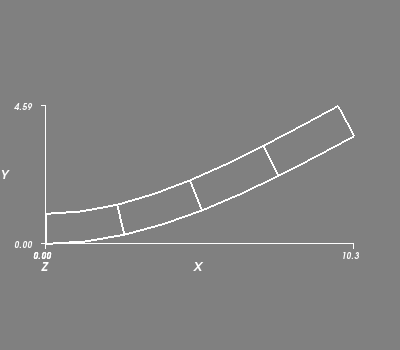

In [27]:
plot_vtk2('u11.vtk', 'u11.png')

Notebook initialized with ipy backend.


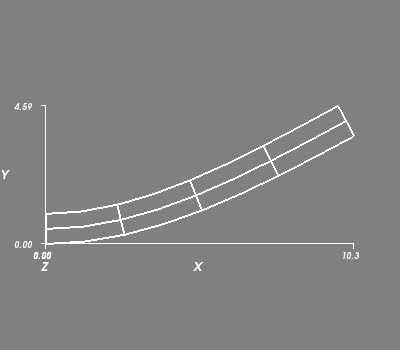

In [28]:
plot_vtk2('u12.vtk', 'u12.png')

Notebook initialized with ipy backend.


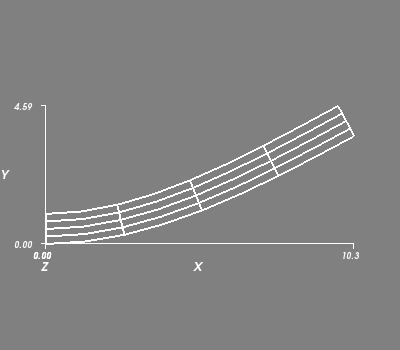

In [29]:
plot_vtk2('u13.vtk', 'u13.png')

Notebook initialized with ipy backend.


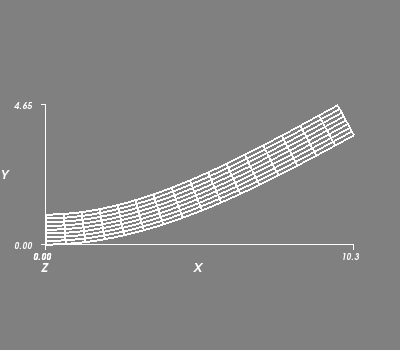

In [30]:
plot_vtk2('u14.vtk', 'u14.png')

Notebook initialized with ipy backend.


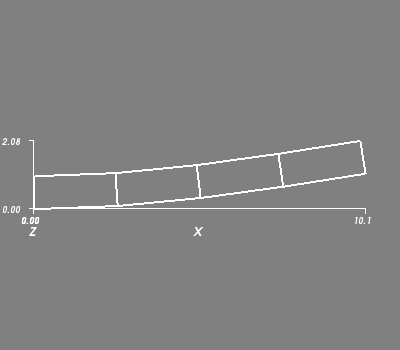

In [31]:
plot_vtk2('u21.vtk', 'u21.png')

Notebook initialized with ipy backend.


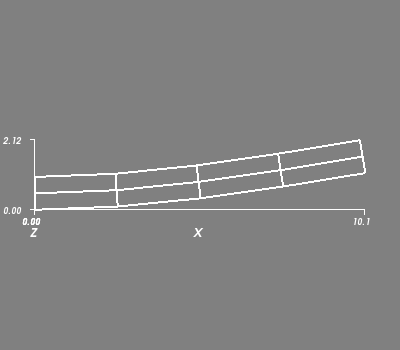

In [32]:
plot_vtk2('u22.vtk', 'u22.png')

Notebook initialized with ipy backend.


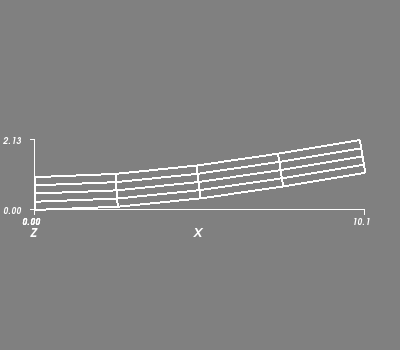

In [33]:
plot_vtk2('u23.vtk', 'u23.png')

Notebook initialized with ipy backend.


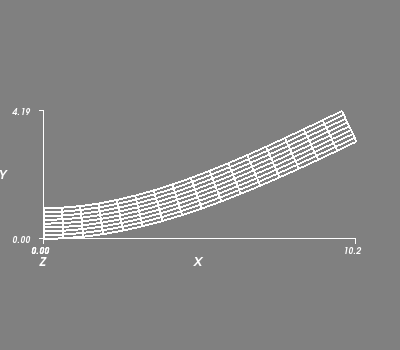

In [34]:
plot_vtk2('u24.vtk', 'u24.png')

Notebook initialized with ipy backend.


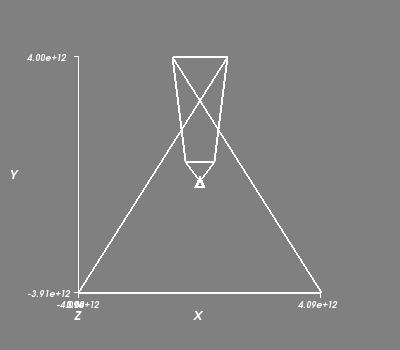

In [35]:
plot_vtk2('u31.vtk', 'u31.png')

Notebook initialized with ipy backend.


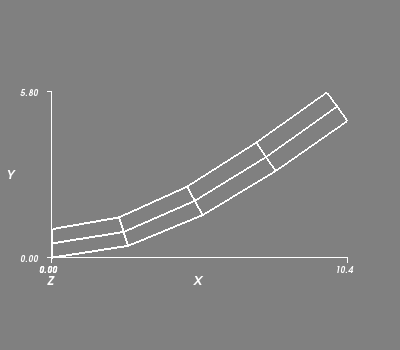

In [36]:
plot_vtk2('u32.vtk', 'u32.png')

Notebook initialized with ipy backend.


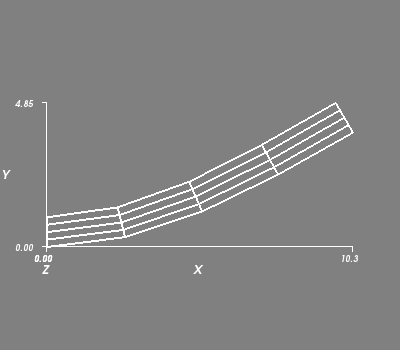

In [37]:
plot_vtk2('u33.vtk', 'u33.png')

Notebook initialized with ipy backend.


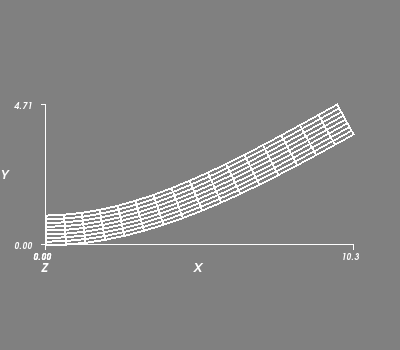

In [38]:
plot_vtk2('u34.vtk', 'u34.png')

Notebook initialized with ipy backend.


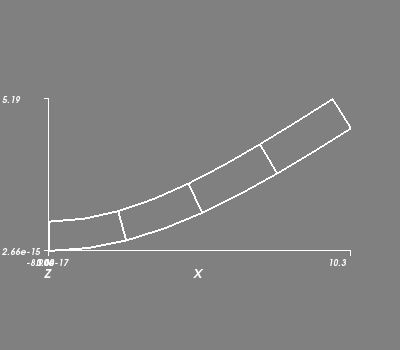

In [39]:
plot_vtk2('u41.vtk', 'u41.png')

Notebook initialized with ipy backend.


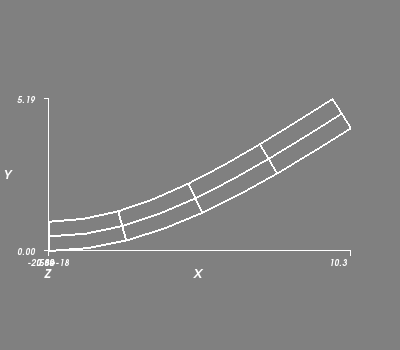

In [40]:
plot_vtk2('u42.vtk', 'u42.png')

Notebook initialized with ipy backend.


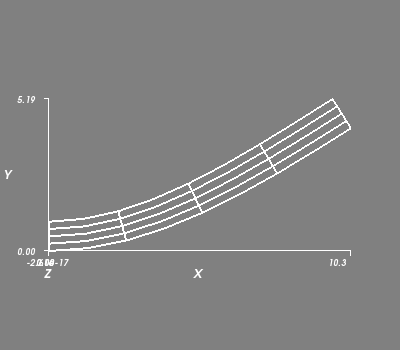

In [41]:
plot_vtk2('u43.vtk', 'u43.png')

Notebook initialized with ipy backend.


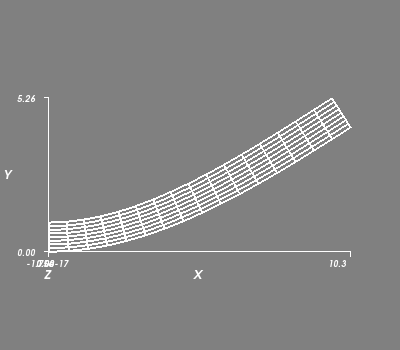

In [42]:
plot_vtk2('u44.vtk', 'u44.png')